### `import` Packages

In [1]:
import os
import json

import pandas as pd
import numpy as np
import geopandas as gpd
import plotly.express as px

### Data Reading

The operating system is Windows 11.

In [2]:
project_path = '\\'.join(os.getcwd().split('\\')[:-1]) + '\\'
dataset_path = project_path + 'Datasets' + '\\'

There are two files in the folder.

In [3]:
os.path.isdir(dataset_path)

True

In [4]:
os.listdir(dataset_path)

['telangana_fires.csv', 'telangana_shapefile.geojson']

In [5]:
# CSV file
tf_df = pd.read_csv(filepath_or_buffer=dataset_path + 'telangana_fires.csv')
# GeoJSON file
tf_geo = gpd.read_file(filename=dataset_path + 'telangana_shapefile.geojson')

In [6]:
tf_df.head(2)

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,18.3777,80.5314,318.6,1.0,1.0,2015-01-02,802,Aqua,MODIS,69,6.03,302.6,7.7,D,0
1,17.5898,80.9893,315.4,1.2,1.1,2015-01-04,750,Aqua,MODIS,59,6.03,299.5,8.8,D,0


The problem with the above dataset is that there is no district column with which we can solve the task. Hence we need to somehow extract the districts.

For this, we need another shape that actually contains districts of Telangana.

### Telangana Level 3

Source → https://gadm.org/download_country.html

* Download the data from the above link.
* Read the data using geopandas.
* Filter the data only for Telangana.
* Write the Telangana data into a folder.

> For the record, I have already done the above steps and saved only Telangana data.

In [7]:
tf_districts = gpd.read_file(filename='telangana_adm/')
tf_districts.columns = ['distname', 'geometry']

<AxesSubplot:>

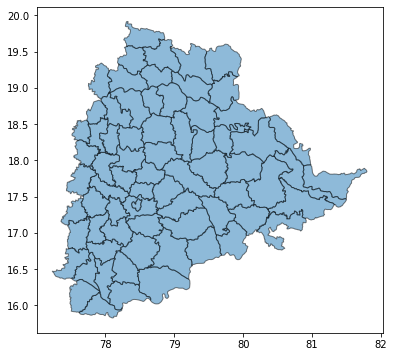

In [8]:
tf_districts.plot(figsize=(10, 6), alpha=0.5, edgecolor='k')

### Convert `df` into `gdf`

In [9]:
def df_to_gdf(df, lat_column, lon_column):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[lon_column], df[lat_column]), crs=4326)
    return gdf

In [10]:
tf_gdf = df_to_gdf(df=tf_df, lat_column='latitude', lon_column='longitude')

In [11]:
type(tf_gdf)

geopandas.geodataframe.GeoDataFrame

### Spatial Joining

In [12]:
tf_main_gdf = gpd.sjoin(left_df=tf_gdf, right_df=tf_districts, how='right')

# data organization
tf_main_gdf.drop(columns=['index_left'], axis=1, inplace=True)
tf_main_gdf.sort_values(by=['acq_date'], inplace=True)
tf_main_gdf.reset_index(drop=True, inplace=True)

In [13]:
tf_main_gdf.head(2)

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,distname,geometry
0,18.3777,80.5314,318.6,1.0,1.0,2015-01-02,802,Aqua,MODIS,69,6.03,302.6,7.7,D,0,Venkatapuram,"POLYGON ((80.38156 18.59360, 80.38558 18.59649..."
1,17.5898,80.9893,315.4,1.2,1.1,2015-01-04,750,Aqua,MODIS,59,6.03,299.5,8.8,D,0,Borgampad,"POLYGON ((81.49374 17.46600, 81.49586 17.46037..."


### Extract `year`

In [14]:
def extract_year(date):
    date = str(date)
    year = int(date.split('-')[0])
    return year

tf_main_gdf['year'] = tf_main_gdf['acq_date'].apply(func=extract_year)

### `gdf` to `JSON`

In [15]:
years = list(tf_main_gdf['year'].unique())
districts = list(tf_main_gdf['distname'].unique())

In [16]:
def get_count(gdf, year, distname):
    gdf = gdf[gdf['year'] == year]
    gdf = gdf[gdf['distname'] == distname]
    return gdf.shape[0]

### Writing into File

In [17]:
def get_JSON(gdf, year_list, district_list, write_to_file=True):    
    if write_to_file:        
        file_name = 'output1.json'
        
        if not os.path.isfile(path=file_name):
            telangana_fdata = {}
    
            for year in year_list:

                years_based = []
                for distname in district_list:
                    ydc = get_count(gdf=gdf, year=year, distname=distname)
                    jd = {
                        'district' : distname,
                        'fireCount' : ydc
                    }
                    years_based.append(jd)

                telangana_fdata[str(year)] = years_based

            json_data = {
                'Telangana' : telangana_fdata
            }
            
            with open(file=file_name, mode='w', encoding='utf-8') as f:
                json.dump(json_data, f, ensure_ascii=False, indent=2)
            print('Please check your working directory. The file is saved successfully.')
        
        else:
            print('Data already exists in the working directory.')
        
        return None
    
    return None

### Read File

In [18]:
file_name = 'output1.json'
if not os.path.isfile(path=file_name):
    # call the function
    get_JSON(
        gdf=tf_main_gdf, year_list=years, district_list=districts
    )
    # read the file
    with open(file=file_name, mode='r', encoding='utf-8') as f:
        telangana_data = json.load(fp=f)
else:
    print('Data already exists in the working directory')
    with open(file=file_name, mode='r', encoding='utf-8') as f:
        telangana_data = json.load(fp=f)

Data already exists in the working directory


### 2015

In [19]:
telangana_data['Telangana']['2015']

[{'district': 'Venkatapuram', 'fireCount': 182},
 {'district': 'Borgampad', 'fireCount': 98},
 {'district': 'Yellandu', 'fireCount': 210},
 {'district': 'Bhadrachalam', 'fireCount': 60},
 {'district': 'Nirmal', 'fireCount': 46},
 {'district': 'Sultanabad', 'fireCount': 21},
 {'district': 'Madhira', 'fireCount': 17},
 {'district': 'Banswada', 'fireCount': 24},
 {'district': 'Huzurnagar', 'fireCount': 8},
 {'district': 'Achampet', 'fireCount': 138},
 {'district': 'Mulug', 'fireCount': 218},
 {'district': 'Manthani', 'fireCount': 104},
 {'district': 'Siddipet', 'fireCount': 7},
 {'district': 'Narsampet', 'fireCount': 135},
 {'district': 'Parkal', 'fireCount': 30},
 {'district': 'Bodhan', 'fireCount': 40},
 {'district': 'Metpalli', 'fireCount': 27},
 {'district': 'Mahbubnagar', 'fireCount': 7},
 {'district': 'Kottagudem', 'fireCount': 95},
 {'district': 'Nizamabad', 'fireCount': 38},
 {'district': 'Narsapur', 'fireCount': 8},
 {'district': 'Sangareddi', 'fireCount': 14},
 {'district': 'Jan

To view the entire data, please check `output1.json` file.

### Choropleth Visualization

In [20]:
def plot_choropleth(gdf, geo_gdf):
    df = gdf.groupby(by=['year', 'distname']).count().reset_index()
    df = df[['year', 'distname', 'frp']]
    df.columns = ['year', 'district', 'fire_cases']
    
    # telangana latitude and longitude
    clat = 18.1124
    clon = 79.0193
    
    # figure plot
    fig = px.choropleth_mapbox(
        data_frame=df,
        geojson=geo_gdf.__geo_interface__,
        locations='district',
        color='fire_cases',
        featureidkey='properties.distname',
        mapbox_style='carto-positron',
        color_continuous_scale='reds',
        center=dict(lat=clat, lon=clon),
        zoom=6,
        animation_frame='year',
    )
    
    # figure layout
    fig.update_layout(
        autosize=True,
        height=600,
        hovermode='closest',
        showlegend=False,
        margin=dict(l=10, r=10, t=30, b=0)
    )
    fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 500
    fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 5
    
    fig.show()
    
    return None

#### Animation Plot

* Open this [link](https://user-images.githubusercontent.com/63333753/158045636-ec586ca0-60f4-4d05-bf68-fd52a5a6fa54.gif) to view the GIF.

In [21]:
# plot_choropleth(gdf=tf_main_gdf, geo_gdf=tf_districts)

<img src="https://user-images.githubusercontent.com/63333753/158045636-ec586ca0-60f4-4d05-bf68-fd52a5a6fa54.gif">

### Geo-Density Visualization

In [22]:
def plot_geodensity(gdf):
    df = gdf[['year', 'latitude', 'frp', 'longitude']]
    
    # telangana latitude and longitude
    clat = 18.1124
    clon = 79.0193
    
    # figure plot
    fig = px.density_mapbox(
        data_frame=df,
        lat='latitude',
        lon='longitude',
        z='frp',
        radius=12,
        center=dict(lat=clat, lon=clon),
        mapbox_style='carto-positron',
        color_continuous_scale='viridis',
        zoom=6,
        animation_frame='year',
    )
    
    # figure layout
    fig.update_layout(
        autosize=True,
        height=600,
        hovermode='closest',
        showlegend=False,
        margin=dict(l=10, r=10, t=30, b=0)
    )
    fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 500
    fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 5
    
    fig.show()
    
    return None

#### Animation Plot

* Open this [link](https://user-images.githubusercontent.com/63333753/158045781-45463dc7-b810-4dd7-9f6c-f1a8f82c4f18.gif) to view the GIF.

In [23]:
# plot_geodensity(gdf=tf_main_gdf)

<img src="https://user-images.githubusercontent.com/63333753/158045781-45463dc7-b810-4dd7-9f6c-f1a8f82c4f18.gif">

### EoF